# Huggingface Sagemaker-sdk - training with custom metrics
### Binary Classification with `Trainer` and `imdb` dataset

In this demo, we extend the basic classification demo by adding **metrics definition** to capture and visualize training metrics.

The documentation of the SageMaker metrics capture feature can be seen at https://docs.aws.amazon.com/sagemaker/latest/dg/training-metrics.html

We additionally use **SageMaker Checkpointing** to send intermediary checkpoint data to S3 uncompressed in parallel to the training happening https://docs.aws.amazon.com/sagemaker/latest/dg/model-checkpoints.html


SageMaker Checkpointing is supported by HF Trainer after Transformers 4.4.0+

## Import libraries and set environment

_*Note:* we only install the required libraries from Hugging Face and AWS. You also need PyTorch or Tensorflow, if you haven´t it installed_

In [ ]:
!pip install "sagemaker>=2.140.0" "transformers==4.26.1" "datasets[s3]==2.10.1" --upgrade

## Development environment 

In [2]:
import sagemaker.huggingface

## Permissions

_If you are going to use Sagemaker in a local environment. You need access to an IAM Role with the required permissions for Sagemaker. You can find [here](https://docs.aws.amazon.com/sagemaker/latest/dg/sagemaker-roles.html) more about it._

In [ ]:
import sagemaker
import boto3
sess = sagemaker.Session()
# sagemaker session bucket -> used for uploading data, models and logs
# sagemaker will automatically create this bucket if it not exists
sagemaker_session_bucket=None
if sagemaker_session_bucket is None and sess is not None:
    # set to default bucket if a bucket name is not given
    sagemaker_session_bucket = sess.default_bucket()

try:
    role = sagemaker.get_execution_role()
except ValueError:
    iam = boto3.client('iam')
    role = iam.get_role(RoleName='sagemaker_execution_role')['Role']['Arn']

sess = sagemaker.Session(default_bucket=sagemaker_session_bucket)

print(f"sagemaker role arn: {role}")
print(f"sagemaker bucket: {sess.default_bucket()}")
print(f"sagemaker session region: {sess.boto_region_name}")

# Preprocessing

We are using the `datasets` library to download and preprocess the `imdb` dataset. After preprocessing, the dataset will be uploaded to our `sagemaker_session_bucket` to be used within our training job. The [imdb](http://ai.stanford.edu/~amaas/data/sentiment/) dataset consists of 25000 training and 25000 testing highly polar movie reviews.

## Tokenization 

In [4]:
from datasets import load_dataset
from transformers import AutoTokenizer

# tokenizer used in preprocessing
tokenizer_name = 'distilbert-base-uncased'

# dataset used
dataset_name = 'imdb'

# s3 key prefix for the data
s3_prefix = 'samples/datasets/imdb'

In [ ]:
# load dataset
dataset = load_dataset(dataset_name)

# download tokenizer
tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)

# tokenizer helper function
def tokenize(batch):
    return tokenizer(batch['text'], padding='max_length', truncation=True)

# load dataset
train_dataset, test_dataset = load_dataset('imdb', split=['train', 'test'])
test_dataset = test_dataset.shuffle().select(range(10000)) # smaller the size for test dataset to 10k 


# tokenize dataset
train_dataset = train_dataset.map(tokenize, batched=True)
test_dataset = test_dataset.map(tokenize, batched=True)

# set format for pytorch
train_dataset =  train_dataset.rename_column("label", "labels")
train_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])
test_dataset = test_dataset.rename_column("label", "labels")
test_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])

## Uploading data to Amazon S3

After we processed the `datasets` we are going to use the new `FileSystem` [integration](https://huggingface.co/docs/datasets/filesystems.html) to upload our dataset to S3.

In [6]:
# save train_dataset to s3
training_input_path = f's3://{sess.default_bucket()}/{s3_prefix}/train'
train_dataset.save_to_disk(training_input_path)

# save test_dataset to s3
test_input_path = f's3://{sess.default_bucket()}/{s3_prefix}/test'
test_dataset.save_to_disk(test_input_path)

Saving the dataset (0/1 shards):   0%|          | 0/25000 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/10000 [00:00<?, ? examples/s]

# Launching a Training Job with custom metrics

In [7]:
from sagemaker.huggingface import HuggingFace

# hyperparameters, which will be passed into the training job
hyperparameters={
    'epochs': 3,
    'train_batch_size': 32,
    'checkpoints': '/opt/ml/checkpoints/',
    'model_name':'distilbert-base-uncased'}

We create a metric_definition dictionary that contains regex-based definitions that will be used to parse the job logs and extract metrics

In [8]:
metric_definitions=[
    {'Name': 'loss', 'Regex': "'loss': ([0-9]+(.|e\-)[0-9]+),?"},
    {'Name': 'learning_rate', 'Regex': "'learning_rate': ([0-9]+(.|e\-)[0-9]+),?"},
    {'Name': 'eval_loss', 'Regex': "'eval_loss': ([0-9]+(.|e\-)[0-9]+),?"},
    {'Name': 'eval_accuracy', 'Regex': "'eval_accuracy': ([0-9]+(.|e\-)[0-9]+),?"},
    {'Name': 'eval_f1', 'Regex': "'eval_f1': ([0-9]+(.|e\-)[0-9]+),?"},
    {'Name': 'eval_precision', 'Regex': "'eval_precision': ([0-9]+(.|e\-)[0-9]+),?"},
    {'Name': 'eval_recall', 'Regex': "'eval_recall': ([0-9]+(.|e\-)[0-9]+),?"},
    {'Name': 'eval_runtime', 'Regex': "'eval_runtime': ([0-9]+(.|e\-)[0-9]+),?"},
    {'Name': 'eval_samples_per_second', 'Regex': "'eval_samples_per_second': ([0-9]+(.|e\-)[0-9]+),?"},
    {'Name': 'epoch', 'Regex': "'epoch': ([0-9]+(.|e\-)[0-9]+),?"}]

In [9]:
huggingface_estimator = HuggingFace(
    entry_point='train.py',
    source_dir='./scripts',
    instance_type='ml.p3.2xlarge',
    instance_count=1,
    transformers_version='4.26',
    pytorch_version='1.13',
    py_version='py39',
    role=role,
    hyperparameters=hyperparameters,
    metric_definitions=metric_definitions)

In [ ]:
# starting the train job with our uploaded datasets as input
huggingface_estimator.fit({'train': training_input_path, 'test': test_input_path})

## Accessing Training Metrics

The training job doesn't emit metrics immediately. For example, it first needs to provision a training instance, download the training image, download the data. Additionally in this demo the first evaluation logs come after 500 steps (default in the Hugging Face trainer https://huggingface.co/transformers/main_classes/trainer.html#transformers.TrainingArguments).

Hence, **run the below section 15 to 20 minutes after launching the training, otherwise it may not have available metrics yet and return an error**

Note that you can also copy this code and run it from a different place (as long as connected to the cloud and authorized to use the API), by specifiying the exact training job name in the `TrainingJobAnalytics` API call.)

In [11]:
from sagemaker import TrainingJobAnalytics

# Captured metrics can be accessed as a Pandas dataframe
df = TrainingJobAnalytics(training_job_name=huggingface_estimator.latest_training_job.name).dataframe()
df.head(10)

INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole


,timestamp,metric_name,value
0,0.0,loss,0.347100
1,300.0,loss,0.211800
2,540.0,loss,0.150400
3,780.0,loss,0.072300
4,0.0,learning_rate,0.000050
5,300.0,learning_rate,3.645720
6,540.0,learning_rate,2.291441
7,780.0,learning_rate,9.371614
8,0.0,eval_loss,0.184432
9,420.0,eval_loss,0.184467


We can also plot some of the metrics collected

*Note: the plot below were generated at the end of the training job, with metrics available for all training duration*

In [ ]:
!pip install seaborn

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns

plt.rcParams['figure.figsize'] = [15,5]

<AxesSubplot:xlabel='timestamp', ylabel='value'>

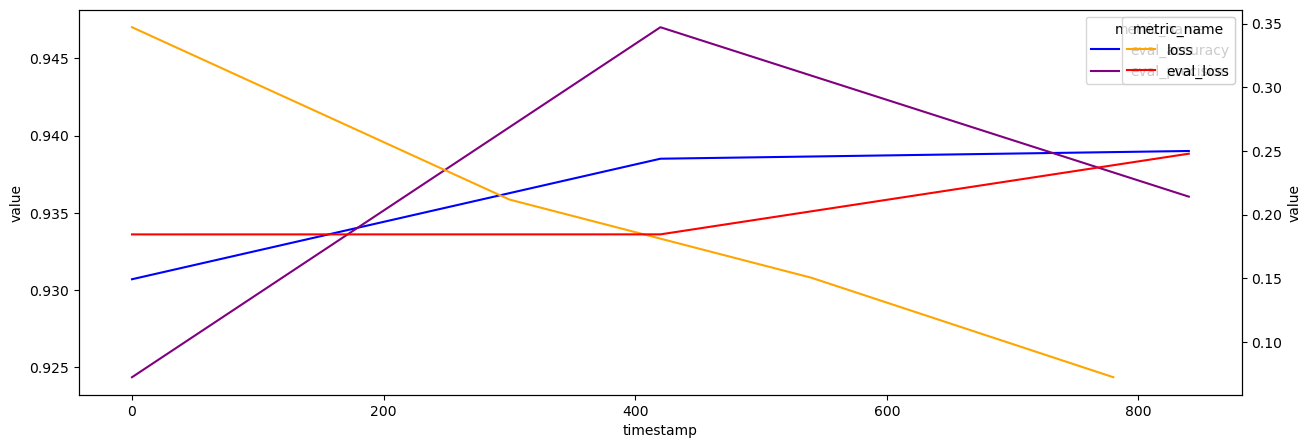

In [14]:
evals = df[df.metric_name.isin(['eval_accuracy','eval_precision'])]
losses = df[df.metric_name.isin(['loss', 'eval_loss'])]

sns.lineplot(
    x='timestamp', 
    y='value', 
    data=evals, 
    hue='metric_name', 
    palette=['blue', 'purple'])

ax2 = plt.twinx()
sns.lineplot(
    x='timestamp', 
    y='value', 
    data=losses, 
    hue='metric_name', 
    palette=['orange', 'red'],
    ax=ax2)

## Deploying the endpoint

To deploy our endpoint, we call `deploy()` on our HuggingFace estimator object, passing in our desired number of instances and instance type.

In [ ]:
predictor = huggingface_estimator.deploy(1,"ml.g4dn.xlarge")

Then, we use the returned predictor object to call the endpoint.

In [ ]:
sentiment_input= {"inputs":"I love using the new Inference DLC."}

predictor.predict(sentiment_input)

Finally, we delete the endpoint again.

In [12]:
predictor.delete_model()
predictor.delete_endpoint()